<a href="https://colab.research.google.com/github/ninja18/deeplearning-practice/blob/main/attentions/additive-attention/seq2seq-de-en-translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Additive attention
Paper: [Neural machine translation by jointly learning to align and translate](https://arxiv.org/pdf/1409.0473) - Bahdanau et. al 2015

Dataset: [Multi30K English to Deutsche dataset](https://huggingface.co/datasets/bentrevett/multi30k)

Model: Use LSTM as encoder and decoder

#### Model variation
- BiLSTM encoder + LSTM decoder

This is the initial seq2seq model training. Look at the other notebook for the attention implementation.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
try:
    import google.colab
    is_running_on_colab = True
except ImportError:
    is_running_on_colab = False

In [3]:
# colab specifics
if is_running_on_colab:
    %pip install early-stopping-pytorch torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [4]:
import random
import numpy as np
import torch

SEED = 1557
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
from datasets import load_dataset

train_dataset = load_dataset("bentrevett/multi30k", split="train")
print(len(train_dataset))
print(train_dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

29000
{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


In [6]:
import re

TOKEN_RE = re.compile(r"\w+|[^\w\s]")
def word_tokenize(text):
    text = text.lower().strip()
    return TOKEN_RE.findall(text)

In [7]:
word_tokenize("Hello, world!")

['hello', ',', 'world', '!']

In [8]:
from collections import Counter

PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"

SPECIAL_TOKENS = [PAD, BOS, EOS, UNK]

def build_vocab(tokenized_texts, max_vocab_size=10000, min_freq=3):
    counter = Counter(token for text in tokenized_texts for token in text)
    vocab = SPECIAL_TOKENS.copy()

    for token, freq in counter.most_common():
        if freq < min_freq:
            break
        if len(vocab) >= max_vocab_size:
            break
        if token not in vocab:
            vocab.append(token)

    vocab_to_index = {token: index for index, token in enumerate(vocab)}
    index_to_vocab = {index: token for token, index in vocab_to_index.items()}

    return vocab_to_index, index_to_vocab

In [9]:
def add_special_tokens(tokens):
    return [BOS] + tokens + [EOS]

def remove_special_tokens(tokens):
    return [token for token in tokens if token not in [PAD, BOS, EOS]]

def encode(token_to_index, text):
    return [token_to_index.get(token, token_to_index[UNK]) for token in text]

def decode(index_to_token, indices):
    for i, index in enumerate(indices):
        if index_to_token.get(index) == EOS:
            return " ".join(remove_special_tokens([index_to_token.get(index, UNK) for index in indices[:i]]))
    return " ".join(remove_special_tokens([index_to_token.get(index, UNK) for index in indices]))


In [10]:
# Load data and build vocab
tokenized_train_dataset = train_dataset.map(lambda x: {"en": word_tokenize(x["en"]), "de": word_tokenize(x["de"])}, batched=False)

en_vocab_to_index, en_index_to_vocab = build_vocab(
    [item["en"] for item in tokenized_train_dataset]
)
de_vocab_to_index, de_index_to_vocab = build_vocab(
    [item["de"] for item in tokenized_train_dataset]
)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

In [11]:
print(f"English Vocab size: {len(en_vocab_to_index)}")
print(f"German Vocab size: {len(de_vocab_to_index)}")
print(tokenized_train_dataset[0])

English Vocab size: 4560
German Vocab size: 5422
{'en': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], 'de': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']}


In [12]:
def preprocess(batch, source_lang, target_lang, source_vocab_to_index, target_vocab_to_index):
    source_encodings = [encode(source_vocab_to_index, add_special_tokens(word_tokenize(text))) for text in batch[source_lang]]
    target_encodings = [encode(target_vocab_to_index, add_special_tokens(word_tokenize(text))) for text in batch[target_lang]]

    return {"source": source_encodings, "target": target_encodings}

In [13]:
preprocessed_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
preprocessed_train_dataset.set_format(type="torch", columns=["source", "target"])

print(preprocessed_train_dataset[0])
print(f"German: {decode(de_index_to_vocab, preprocessed_train_dataset[0]['source'].tolist())}")
print(f"English: {decode(en_index_to_vocab, preprocessed_train_dataset[0]['target'].tolist())}")

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

{'source': tensor([   1,   18,   27,  215,   31,   85,   20,   89,    7,   15,  115,    3,
        3149,    4,    2]), 'target': tensor([   1,   16,   24,   15,   25,  776,   17,   57,   80,  204, 1305,    5,
           2])}
German: zwei junge weiße männer sind im freien in der nähe <unk> büsche .
English: two young , white males are outside near many bushes .


In [14]:
import torch

def pad_batch(sequences, pad_idx=0):
    dtype = sequences[0].dtype

    lengths = torch.tensor([len(seq) for seq in sequences])
    max_length = int(lengths.max().item())

    padded_batch = torch.full((len(sequences), max_length), pad_idx, dtype=dtype)
    for i, seq in enumerate(sequences):
        end = lengths[i]
        padded_batch[i, :end] = seq
    return padded_batch, lengths

def collate_fn(batch):
    source = [item["source"] for item in batch]
    target = [item["target"] for item in batch]

    source, source_lengths = pad_batch(source) # defer padding till batching
    target, target_lengths = pad_batch(target)

    return {"source": source, "source_lengths": source_lengths, "target": target, "target_lengths": target_lengths}

In [15]:
from torch.utils.data import DataLoader
loader = DataLoader(
    preprocessed_train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn,
)

batch = next(iter(loader))
print(batch["source"].shape)
print(batch["source_lengths"].shape)
print(batch["target"].shape)
print(batch["target_lengths"].shape)

torch.Size([3, 15])
torch.Size([3])
torch.Size([3, 16])
torch.Size([3])


In [16]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, device, padding_idx=0):
        super().__init__()
        self.device = device
        self.directions = 2
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout if num_layers > 1 else 0.0, batch_first=True, bidirectional=True)
        self.hidden_projection = nn.Linear(2 * hidden_dim, hidden_dim)
        self.cell_projection = nn.Linear(2 * hidden_dim, hidden_dim)

    def forward(self, source_encodings, source_lengths): # source_encodings: (batch_size, max_length), source_lengths: (batch_size)
        B, T = source_encodings.size()
        h_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)
        c_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)

        embedded = self.embedding(source_encodings) # (B, T, embedding_dim)
        embedded = self.dropout(embedded)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, source_lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_outputs, (last_hidden, last_cell) = self.lstm(packed_embedded, (h_0, c_0)) # hidden: (num_layers * directions, B, hidden_dim)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True) # outputs: (B, T, hidden_dim * directions)

        h_f = last_hidden[0::2] # (num_layers, B, hidden_dim)
        h_b = last_hidden[1::2] # (num_layers, B, hidden_dim)
        h_cat = torch.cat((h_f, h_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension

        c_f = last_cell[0::2] # (num_layers, B, hidden_dim)
        c_b = last_cell[1::2] # (num_layers, B, hidden_dim)
        c_cat = torch.cat((c_f, c_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension

        last_hidden = torch.tanh(self.hidden_projection(h_cat)) # (num_layers, B, hidden_dim)
        last_cell = torch.tanh(self.cell_projection(c_cat)) # (num_layers, B, hidden_dim)

        return outputs, last_hidden, last_cell


In [17]:
encoder = Encoder(len(de_vocab_to_index), 120, 256, 2, 0.0, 'cpu')

outputs, last_hidden, last_cell = encoder(batch["source"], batch["source_lengths"])

print(f"outputs (B, T, hidden_dim * directions): {outputs.shape}")
print(f"last_hidden (num_layers * directions, B, hidden_dim): {last_hidden.shape}")
print(f"last_cell (num_layers * directions, B, hidden_dim): {last_cell.shape}")

print(f"last_hidden: {last_hidden}")


outputs (B, T, hidden_dim * directions): torch.Size([3, 15, 512])
last_hidden (num_layers * directions, B, hidden_dim): torch.Size([2, 3, 256])
last_cell (num_layers * directions, B, hidden_dim): torch.Size([2, 3, 256])
last_hidden: tensor([[[ 2.7087e-02, -6.1209e-02, -1.4815e-02,  ...,  1.9722e-02,
          -3.7388e-02, -2.1360e-02],
         [ 2.5211e-02, -3.1794e-02, -1.1095e-02,  ...,  1.7036e-02,
          -1.7297e-02, -5.8430e-03],
         [ 5.5512e-02, -5.2913e-02, -5.8107e-03,  ...,  2.6833e-02,
          -1.9347e-02, -4.1027e-02]],

        [[-6.8816e-03, -3.6020e-02, -8.7713e-03,  ..., -2.6719e-02,
           2.2928e-02,  5.5497e-03],
         [-9.2412e-04, -3.9845e-02, -8.9638e-05,  ..., -2.4526e-02,
           2.3791e-02,  7.2831e-03],
         [-2.3866e-03, -3.6656e-02, -5.3476e-03,  ..., -3.2279e-02,
           2.7942e-02,  1.0705e-02]]], grad_fn=<TanhBackward0>)


In [27]:
class Decoder(nn.Module):
    """
    Decoder for the Seq2Seq model. This works on a batch of single step targets (B, 1).
    It doesn't take the entire target sequence, because the decision to teacher force and what kind of search strategy to use
    is done at the sequence level, not the step level.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, padding_idx=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=False,
        )
        self.output_projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs, encoder_last_hidden, encoder_last_cell):
        # Note: (B, 1) is needed because the LSTM expects a 2D input (batch_size, sequence_length)
        inputs = inputs.unsqueeze(1) # (B, 1)

        embedded = self.embedding(inputs)  # (B, 1, embedding_dim)
        embedded = self.dropout(embedded)

        outputs, (hidden, cell) = self.lstm(embedded, (encoder_last_hidden, encoder_last_cell)) # (B, 1, hidden_dim)
        outputs = self.dropout(outputs)
        logits = self.output_projection(outputs) # (B, 1, vocab_size)

        # No attention weights for this decoder
        return logits, hidden, cell, None

In [28]:
decoder = Decoder(len(en_vocab_to_index), 120, 256, 2, 0.0)

# One decoding step for the whole batch (B,)
step0 = batch["target"][:, 0]
print(step0.shape, step0)

logits, hidden, cell, _ = decoder(step0, last_hidden, last_cell)
print(f"logits (B, 1, vocab_size): {logits.shape}")
print(f"hidden (num_layers, B, hidden_dim): {hidden.shape}")
print(f"cell (num_layers, B, hidden_dim): {cell.shape}")
print(logits)


torch.Size([3]) tensor([1, 1, 1])
logits (B, 1, vocab_size): torch.Size([3, 1, 4560])
hidden (num_layers, B, hidden_dim): torch.Size([2, 3, 256])
cell (num_layers, B, hidden_dim): torch.Size([2, 3, 256])
tensor([[[-0.0469,  0.0562,  0.0008,  ...,  0.0431, -0.0584,  0.0065]],

        [[-0.0368,  0.0588,  0.0053,  ...,  0.0439, -0.0626,  0.0121]],

        [[-0.0445,  0.0573,  0.0034,  ...,  0.0402, -0.0605,  0.0066]]],
       grad_fn=<ViewBackward0>)


In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, bos_idx, eos_idx, max_target_length, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.max_target_length = max_target_length
        self.device = device

    def forward(self, source, source_lengths, target, teacher_forcing_ratio=0.5):
        B = source.shape[0]
        # Target shape: (B, T) including <bos> and <eos>
        # We process T-1 steps (predicting from <bos> up to second-to-last token)
        target_len = target.shape[1] - 1

        _, hidden, cell = self.encoder(source, source_lengths)

        inputs = target[:, 0]
        outputs = torch.zeros(B, target_len, self.decoder.vocab_size, device=self.device)

        for t in range(0, target_len):
            logits, hidden, cell, _ = self.decoder(inputs, hidden, cell)
            logits = logits.squeeze(1) # (B, 1, vocab_size) -> (B, vocab_size)
            outputs[:, t] = logits

            top1 = logits.argmax(dim=1)

            teacher_force = random.random() < teacher_forcing_ratio
            inputs = target[:, t + 1] if teacher_force else top1

        return outputs

    @torch.no_grad()
    def generate(self, source, source_lengths, topk=0):
        """
        Inference pass for generating translations.
        Returns predicted indices.
        """
        B = source.shape[0]

        _, hidden, cell = self.encoder(source, source_lengths)

        inputs = torch.full((B,), self.bos_idx, dtype=torch.long, device=self.device)
        preds_all = [] # using list instead of tensor due to its variable length

        for _ in range(self.max_target_length):
            logits, hidden, cell, _ = self.decoder(inputs, hidden, cell)
            step_logits = logits.squeeze(1) # (B, 1, vocab_size) -> (B, vocab_size)

            if topk > 0:
                step_preds = self._topk_decode(step_logits, topk)
            else:
                step_preds = step_logits.argmax(dim=1)

            preds_all.append(step_preds.unsqueeze(1))
            inputs = step_preds

            if step_preds.eq(self.eos_idx).all():
                break

        # No attention weights for this encoder-decoder
        return torch.cat(preds_all, dim=1), None

    def _topk_decode(self, logits, topk):
        topk_logits, topk_vocab_ids = torch.topk(logits, topk, dim=-1) # (B, k)
        topk_probs = torch.softmax(topk_logits, dim=-1) # (B, k)
        sample_pos = torch.multinomial(topk_probs, num_samples=1) # (B, 1)
        preds = topk_vocab_ids.gather(1, sample_pos) # (B, 1)
        return preds.squeeze(1)

In [32]:
criterion = nn.CrossEntropyLoss(ignore_index=de_vocab_to_index[PAD])

In [33]:
model = Seq2Seq(encoder, decoder, de_vocab_to_index[BOS], de_vocab_to_index[EOS], 30, 'cpu')

logits_all = model(batch["source"], batch["source_lengths"], batch["target"])
target = batch["target"][:, 1:].reshape(-1)
loss = criterion(logits_all.reshape(-1, logits_all.shape[-1]), target)

print(f"logits_all.shape: {logits_all.shape}")
print(f"batch['target'].shape: {batch['target'].shape}")
print(f"loss: {loss}\n")

logits_all.shape: torch.Size([3, 15, 4560])
batch['target'].shape: torch.Size([3, 16])
loss: 8.41602611541748



In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [35]:
tgt_vocab_size = len(en_vocab_to_index) # 4560
src_vocab_size = len(de_vocab_to_index) # 5422
emb_dim = 512
hidden_dim = 512
enc_num_layers = 2
dec_num_layers = 2
enc_dropout = 0.3
dec_dropout = 0.3
padding_idx = de_vocab_to_index[PAD]
bos_idx = de_vocab_to_index[BOS]
eos_idx = de_vocab_to_index[EOS]
max_target_length = 25

batch_size = 128
learning_rate = 0.0005
epochs = 30
max_grad_norm = 1.0
topk = 5
early_stopping_patience = 5
teacher_forcing_decay_constant = epochs / 4 # to get even 25% decrease

In [62]:
basic_encoder = Encoder(src_vocab_size, emb_dim, hidden_dim, enc_num_layers, enc_dropout, device, padding_idx)
basic_decoder = Decoder(tgt_vocab_size, emb_dim, hidden_dim, dec_num_layers, dec_dropout, padding_idx)

basic_model = Seq2Seq(basic_encoder, basic_decoder, bos_idx, eos_idx, max_target_length, device)
basic_model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3)
    (output_projection): Linear(in_features=512, out_features=4560, bias=True)
  )
)

### Model parameter calculation

#### Encoder
- source embedding: vocab * emb_dim + bias
- 2 layers BiLSTM:  
    - direction * gates * ( W_x + W_h + b_x + b_h)
    - direction * gates * ( W_h + W_h + b_h + b_h)
- hidden projection: 2 * (2 * hidden_dim * hidden_dim + b_h)

#### Decoder
- target embedding: vocab * emb_dim + bias
- 2 layers LSTM:
    - gates * ( W_x + W_h + b_x + b_h)
    - gates * ( W_x + W_h + b_x + b_h)
- output projection: hidden_dim * target_vocab + b_v

In [37]:
p_src_emd = src_vocab_size * emb_dim + src_vocab_size
p_enc_lstm_1 = 2 * 4 * (emb_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_enc_lstm_2 = 2 * 4 * (hidden_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_enc_hidden_proj = 2 * (2 * hidden_dim * hidden_dim + hidden_dim)
p_enc_cell_proj = 2 * (2 * hidden_dim * hidden_dim + hidden_dim)

p_encoder = p_src_emd + p_enc_lstm_1 + p_enc_lstm_2 + p_enc_hidden_proj + p_enc_cell_proj

print(f"Encoder parameters: {p_encoder:,}")

p_tgt_emd = tgt_vocab_size * emb_dim + tgt_vocab_size
p_dec_lstm_1 = 4 * (emb_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_dec_lstm_2 = 4 * (hidden_dim * hidden_dim + hidden_dim * hidden_dim + (4*hidden_dim) + (4*hidden_dim))
p_dec_output_proj = hidden_dim * tgt_vocab_size + tgt_vocab_size

p_decoder = p_tgt_emd + p_dec_lstm_1 + p_dec_lstm_2 + p_dec_output_proj

print(f"Decoder parameters: {p_decoder:,}")

p_seq2seq = p_encoder + p_decoder

print(f"Seq2Seq parameters: {p_seq2seq:,}")



Encoder parameters: 13,334,830
Decoder parameters: 8,905,632
Seq2Seq parameters: 22,240,462


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The Seq2Seq model has {count_parameters(basic_model):,} trainable parameters')
print(f"Encoder parameters: {count_parameters(basic_encoder):,}")
print(f"Decoder parameters: {count_parameters(decoder):,}")


The Seq2Seq model has 23,204,304 trainable parameters
Encoder parameters: 14,327,808
Decoder parameters: 2,632,528


### Rough estimate of memory needed
- long or float32 = 4 bytes
- memory for model for Adam optimizer = 4 * mode parameters * 4 bytes
- activations of LSTM = 6 * hidden_dim * num_layers * batch_size * seq_len * 4 bytes
- activations embedding = batch_size * seq_len * embed_dim * 2
- hidden projection activations = batch_size * seq_len * hidden_dim * 2
- output project activation = batch_size * seq_len * tgt_vocab

total = sum of above + 30%

In [39]:
model_memory = 4 * 4 * p_seq2seq
activations_memory = 6 * hidden_dim * (enc_num_layers + dec_num_layers) * batch_size * max_target_length * 4
embedding_memory = batch_size * max_target_length * emb_dim * 2
hidden_projection_memory = batch_size * max_target_length * hidden_dim * 2
output_projection_memory = batch_size * max_target_length * tgt_vocab_size

total_activations_memory = activations_memory + embedding_memory + hidden_projection_memory + output_projection_memory
total_memory = model_memory + total_activations_memory


print(f"Total memory: {total_memory:,} bytes")
print(f"Model memory: {model_memory:,} bytes")
print(f"Activations memory: {activations_memory + embedding_memory + hidden_projection_memory + output_projection_memory:,} bytes")
print(f"Total required memory: {total_memory * 1.3:,} bytes")

Total memory: 534,279,392 bytes
Model memory: 355,847,392 bytes
Activations memory: 178,432,000 bytes
Total required memory: 694,563,209.6 bytes


In [63]:
optimizer = torch.optim.Adam(basic_model.parameters(), lr=learning_rate)

In [41]:
def batch_to_device(batch, device):
    return {k: v.to(device, non_blocking=True) if isinstance(v, torch.Tensor) else v
     for k, v in batch.items()}

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time / 60)
    seconds = int(elapsed_time % 60)
    return minutes, seconds

In [42]:
def train(model, loader, criterion, optimizer, max_grad_norm, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for batch in loader:
        batch = batch_to_device(batch, device)
        optimizer.zero_grad()

        logits_all = model(batch["source"], batch["source_lengths"], batch["target"], teacher_forcing_ratio=teacher_forcing_ratio)
        target = batch["target"][:, 1:].reshape(-1)

        loss = criterion(logits_all.reshape(-1, logits_all.shape[-1]), target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [43]:
@torch.no_grad()
def validate_with_teacher_forcing(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    for batch in loader:
        batch = batch_to_device(batch, device)
        logits_all = model(batch["source"], batch["source_lengths"], batch["target"], teacher_forcing_ratio=1.0)
        target = batch["target"][:, 1:].reshape(-1)

        loss = criterion(logits_all.reshape(-1, logits_all.shape[-1]), target)
        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [61]:
from torchmetrics.text import BLEUScore

@torch.no_grad()
def validate_with_bleu_score(model, loader, device):
    model.eval()
    metric = BLEUScore()

    preds_text = []
    targets_text = []

    for batch in loader:
        batch = batch_to_device(batch, device)
        src = batch["source"]
        src_lengths = batch["source_lengths"]
        trg = batch["target"]

        prediction, _ = model.generate(src, src_lengths)

        for i in range(src.shape[0]):
            target_str = decode(en_index_to_vocab, trg[i].tolist())
            targets_text.append([target_str]) # Expects list of references per sample

            pred_str = decode(en_index_to_vocab, prediction[i].tolist())
            preds_text.append(pred_str)

    score = metric(preds_text, targets_text)
    return score.item()

In [64]:
train_dataset = load_dataset("bentrevett/multi30k", split="train")
val_dataset = load_dataset("bentrevett/multi30k", split="validation")

final_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_train_dataset.set_format(type="torch", columns=["source", "target"])

final_val_dataset = val_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_val_dataset.set_format(type="torch", columns=["source", "target"])

pin_memory = True if device == "cuda" else False

train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)

In [46]:
import json

def save_artifacts(model, train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios, batch_size, learning_rate, epochs, artifacts_path, model_path, max_grad_norm):
    with open(artifacts_path, 'w') as f:
        artifacts = {
        'train_losses': train_losses,
         'val_losses': val_losses,
         'val_bleu_scores': val_bleu_scores,
         'teacher_forcing_ratios': teacher_forcing_ratios,
         'batch_size': batch_size,
         'learning_rate': learning_rate,
         'epochs': epochs,
         'model': str(model),
         'model_path': model_path,
         'max_grad_norm': max_grad_norm,
         }
        json.dump(artifacts, f)


In [72]:
import matplotlib.pyplot as plt
def show_graph(train_losses, val_losses, val_bleu_scores, save_path=None, save=False):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ax1.plot(train_losses, label='Training loss')
    ax1.plot(val_losses, label='Validation loss')
    ax1.legend()
    ax1.set_title("Loss over epochs")

    ax2.plot(val_bleu_scores, label='Validation BLEU')
    ax2.legend()
    ax2.set_title("BLEU over epochs")
    fig.show()
    if save and save_path:
        fig.savefig(save_path)

In [48]:
import math
def inverse_sigmoid_decay(step, k=8):
    """
    Calculates the teacher forcing ratio using inverse sigmoid decay.
    Formula: k / (k + exp(step / k))

    Args:
        step: Current epoch or iteration number (0-indexed).
        k: Decay constant. Larger k means slower decay.
    """
    ratio = k / (k + math.exp(step / k))
    return round(ratio, 2)

In [49]:
for i in range(30):
    print(f"Epoch {i}: {inverse_sigmoid_decay(i, k=8)}")

Epoch 0: 0.89
Epoch 1: 0.88
Epoch 2: 0.86
Epoch 3: 0.85
Epoch 4: 0.83
Epoch 5: 0.81
Epoch 6: 0.79
Epoch 7: 0.77
Epoch 8: 0.75
Epoch 9: 0.72
Epoch 10: 0.7
Epoch 11: 0.67
Epoch 12: 0.64
Epoch 13: 0.61
Epoch 14: 0.58
Epoch 15: 0.55
Epoch 16: 0.52
Epoch 17: 0.49
Epoch 18: 0.46
Epoch 19: 0.43
Epoch 20: 0.4
Epoch 21: 0.37
Epoch 22: 0.34
Epoch 23: 0.31
Epoch 24: 0.28
Epoch 25: 0.26
Epoch 26: 0.24
Epoch 27: 0.21
Epoch 28: 0.19
Epoch 29: 0.18


In [75]:
import time
from early_stopping_pytorch import EarlyStopping


def train_loop(model, train_loader, val_loader, criterion, optimizer, epochs, max_grad_norm, device, model_path, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    train_losses = []
    val_losses = []
    val_bleu_scores = []
    teacher_forcing_ratios = []
    best_valid_loss = float('inf')

    for e in range(epochs):
        start_time = time.time()

        teacher_forcing_ratio = inverse_sigmoid_decay(e, k=teacher_forcing_decay_constant)

        train_loss = train(model, train_loader, criterion, optimizer, max_grad_norm, teacher_forcing_ratio, device)
        val_loss = validate_with_teacher_forcing(model, val_loader, criterion, device)
        val_bleu = validate_with_bleu_score(model, val_loader, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            torch.save(model.state_dict(), model_path)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_bleu_scores.append(val_bleu)
        teacher_forcing_ratios.append(teacher_forcing_ratio)

        print(f"Epoch {e+1}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val BLEU: {val_bleu:.4f}, Teacher forcing ratio: {teacher_forcing_ratio:.4f}, Epoch time: {epoch_mins}m {epoch_secs}s")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break


    return train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios


In [51]:
if is_running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    model_location = '/content/drive/My Drive/ML study/Attentions/additive attention/weights'
    artifacts_location = '/content/drive/My Drive/ML study/Attentions/additive attention/artifacts'
else:
    model_location = 'weights'
    artifacts_location = 'artifacts'

# training_prefix = 'seq2seq-final-model'
training_prefix = 'seq2seq-scheduled-sampling-model'
model_path = f'{model_location}/{training_prefix}.pt'
artifacts_path = f'{artifacts_location}/{training_prefix}-artifacts.json'
loss_graph_path = f'{artifacts_location}/{training_prefix}-loss-graph.png'

Mounted at /content/drive


In [65]:
train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios = train_loop(basic_model, train_loader, val_loader, criterion, optimizer, epochs, max_grad_norm, device, model_path, patience=early_stopping_patience)

Epoch 1: Train loss: 4.8022, Val loss: 3.9609, Val BLEU: 0.0351, Teacher forcing ratio: 0.8800, Epoch time: 0m 32s
Validation loss decreased (inf --> 3.960943).  Saving model ...
Epoch 2: Train loss: 3.9956, Val loss: 3.5659, Val BLEU: 0.0538, Teacher forcing ratio: 0.8700, Epoch time: 0m 33s
Validation loss decreased (3.960943 --> 3.565866).  Saving model ...
Epoch 3: Train loss: 3.7581, Val loss: 3.3507, Val BLEU: 0.0605, Teacher forcing ratio: 0.8500, Epoch time: 0m 33s
Validation loss decreased (3.565866 --> 3.350655).  Saving model ...
Epoch 4: Train loss: 3.5665, Val loss: 3.1816, Val BLEU: 0.0707, Teacher forcing ratio: 0.8300, Epoch time: 0m 33s
Validation loss decreased (3.350655 --> 3.181589).  Saving model ...
Epoch 5: Train loss: 3.4198, Val loss: 3.0298, Val BLEU: 0.0864, Teacher forcing ratio: 0.8100, Epoch time: 0m 33s
Validation loss decreased (3.181589 --> 3.029804).  Saving model ...
Epoch 6: Train loss: 3.3244, Val loss: 2.9209, Val BLEU: 0.0934, Teacher forcing rati

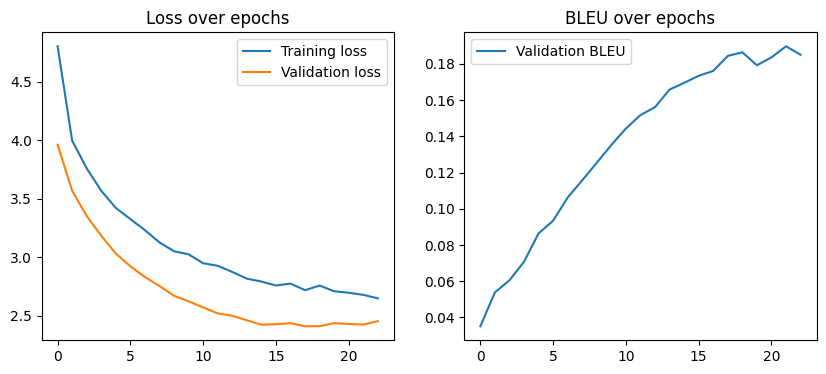

In [77]:
save_artifacts(basic_model, train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios, batch_size, learning_rate, epochs, artifacts_path, model_path, max_grad_norm)
show_graph(train_losses, val_losses, val_bleu_scores, save_path=loss_graph_path, save=True)

#### Observations
The validation loss is always lower than train loss because validation is done with 100% teacher forcing unlike training where the teacher forcing is gradually reduced.

In [78]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

In [79]:
load_model(basic_model, model_path, device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3)
    (output_projection): Linear(in_features=512, out_features=4560, bias=True)
  )
)

In [80]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

In [81]:
@torch.no_grad()
def translate(model, test_loader, device):
    model.eval()

    test_batch = next(iter(test_loader))
    test_batch = batch_to_device(test_batch, device)

    targets = test_batch["target"]
    preds_all, _ = model.generate(test_batch["source"], test_batch["source_lengths"], topk=topk)

    for i in range(preds_all.shape[0]):
        print(f"Source: {decode(de_index_to_vocab, test_batch['source'][i].tolist())}")
        print(f"Pred: {decode(en_index_to_vocab, preds_all[i].tolist())}")
        print(f"Target: {decode(en_index_to_vocab, targets[i].tolist())}")
        print("-"*100)


In [83]:
translate(basic_model, test_loader, device)

Source: ein dj bei der arbeit wird von <unk> <unk> .
Pred: a fisherman is <unk> to his to the customers .
Target: a disc jockey busy at work as lights <unk> upon him .
----------------------------------------------------------------------------------------------------
Source: zwei hunde <unk> sich gegenseitig nase an nase .
Pred: two dogs fight up each other and one
Target: two dogs are <unk> each other nose to nose .
----------------------------------------------------------------------------------------------------
Source: ein chor versammelt sich in einer kirche .
Pred: an artist is performing in an event .
Target: a choir group is gathered together in a church .
----------------------------------------------------------------------------------------------------
Source: ein kind sitzt an einem restauranttisch und hält eine <unk> <unk> gesicht .
Pred: a child is sitting on a table while holding a a bottle of paper .
Target: a child sitting at a restaurant table holding a paper mask a

In [84]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

validate_with_bleu_score(basic_model, test_loader, device)

0.18425241112709045